In [1]:
%load_ext autoreload
%autoreload 2

import json
import pandas as pd
import numpy as np
from equipartition import Equipartition
import matplotlib.pyplot as plt

from astropy import units as u, constants as c

wtn_z = 0.049

# First, read in the files with the literature best-fit parameters

In [2]:
lit = pd.read_csv("lit_sed_params.csv", comment="#")
bhmasses = pd.read_csv("bh_masses_host.txt", sep="\t")
bhmasses["name"] = bhmasses.name.str.strip()

lit

,Name,t,p,epsilon_e,epsilon_B,nu_a,nu_a_error,nu_m,nu_m_error,Fp_mJy,Fp_mJy_error,dist_Mpc,z
0,CNSSJ0019+00,573,3.3,0.1,0.100,4.260000,0.040000,-99.990000,-99.990000,8.270000,0.030,77.1,0.0180
1,CNSSJ0019+00,606,3.3,0.1,0.100,3.870000,0.030000,-99.990000,-99.990000,8.080000,0.040,77.1,0.0180
2,CNSSJ0019+00,731,3.3,0.1,0.100,3.120000,0.040000,-99.990000,-99.990000,7.410000,0.060,77.1,0.0180
3,CNSSJ0019+00,998,3.3,0.1,0.100,1.920000,0.060000,-99.990000,-99.990000,4.950000,0.090,77.1,0.0180
4,ASASSN-14li,128,3.0,0.1,0.100,16.800000,0.000000,-99.990000,-99.990000,1.910000,0.000,90.0,0.0206
5,ASASSN-14li,143,3.0,0.1,0.100,8.200000,0.100000,-99.990000,-99.990000,1.760000,0.010,90.0,0.0206
6,ASASSN-14li,207,3.0,0.1,0.100,4.370000,0.200000,-99.990000,-99.990000,1.230000,0.030,90.0,0.0206
7,ASASSN-14li,246,3.0,0.1,0.100,4.000000,0.060000,-99.990000,-99.990000,1.140000,0.010,90.0,0.0206
8,ASASSN-14li,304,3.0,0.1,0.100,2.550000,0.060000,-99.990000,-99.990000,0.940000,0.020,90.0,0.0206
9,ASASSN-14li,381,3.0,0.1,0.100,1.910000,0.070000,-99.990000,-99.990000,0.620000,0.020,90.0,0.0206


# Now, use the Equipartition class to compute physical properties of the system

In [9]:
# need to compute
# Req, energyeq, magField, Ne, CNMnumDens and betaeqN

# first clean up the data
eq_data = {
    "name":lit.Name,
    "F_p":[],
    "nu_p":[],
    "p":[],
    "t":[],
    "z":[],
    "nu_m":[],
    "nu_a":[],
    "epsilon_B":lit.epsilon_B
}
nsamples = 10
for name, grp in lit.groupby("Name"):
    for _,row in grp.iterrows():
        if row.nu_a > row.nu_m:
            nu_p_key = "nu_a"
        else:
            nu_p_key = "nu_m"
        
        # eq_data["name"].append(row.name)
        eq_data["nu_p"].append(
            np.random.normal(row[nu_p_key]/10, row[nu_p_key+"_error"]/10, nsamples)
        )
        eq_data["F_p"].append(
            np.random.normal(row["Fp_mJy"], row["Fp_mJy_error"], nsamples)
        )
        eq_data["t"].append(row.t)
        eq_data["z"].append(row.z)
        eq_data["p"].append(row.p)
        eq_data["nu_m"].append(
            np.random.normal(row.nu_m/10, row.nu_m_error/10, nsamples)
            if row.nu_m not in {-99.99, 0} 
            else np.array([1]*nsamples)
        )
        eq_data["nu_a"].append(
            np.random.normal(row.nu_a/10, row.nu_a_error/10, nsamples)
            if row.nu_a not in {-99.99, 0} 
            else np.array([1]*nsamples)
        )


# then do the computations
res = []
for name, grp in pd.DataFrame(eq_data).groupby("name"):
    print(name)
    for _,row in grp.iterrows():
        if name == "SwJ1644+57":
            # then this is an on-axis jet
            
            eq = Equipartition(
                row.F_p,
                row.nu_p,
                row.t,
                z = row.z,
                nuA10 = row.nu_a,
                nuM10 = row.nu_m,
                theta = 0,
                p=row.p,
                epse=0.1, 
                epsB=row.epsilon_B, # from Eftekhari+2018
                fOmega=1, # for relativistic on-axis jet
                fA=0.01, # for relativistic on-axis jet
                fV=1, # for relativistic on-axis jet
                newtonian=False, 
                onAxis=True,
                isoNewtonianNe=False,
                corr=True, 
                outofequipartition=True, 
                factorsFour=False,
                hotprotons=True,
                numelectrons=True,
                BDfactor=False
            )
        else:
            outofeq = True
            epsB = row.epsilon_B
            if row.epsilon_B == 0.1:
                outofeq = False
                epsB = None
                
            print(epsB, outofeq, name)
            eq = Equipartition(
                row.F_p,
                row.nu_p,
                row.t,
                z = row.z,
                nuA10 = row.nu_p, # we don't need the energy correction in these cases
                nuM10 = 0, #row.nu_m, # we don't need the energy correction in these cases
                theta = 0,
                p=row.p,
                epse=0.1, 
                epsB=epsB,
                fOmega=16,
                fA=1, 
                fV=0.36, 
                onAxis=False,
                newtonian=True, 
                isoNewtonianNe=False,
                corr=True, 
                outofequipartition=outofeq, 
                factorsFour=False,
                hotprotons=True,
                numelectrons=True,
                BDfactor=False,
                energysum=False
            )

        for key, func in {
            "gammabeta":eq.gammaBeta, 
            "Req":eq.Req, 
            "Eeq":eq.energyeq, 
            "B":eq.magField, 
            "Ne":eq.Ne, 
            "number_density":eq.CNMnumDens
        }.items():
            row[key+"_all"] = func()
            row[key] = np.nanmean(row[key+"_all"])
            row[key+"_err"] = np.nanstd(row[key+"_all"])    
        res.append(row)

eq_res = pd.DataFrame(res)

ASASSN-14li
None False ASASSN-14li
None False ASASSN-14li
None False ASASSN-14li
None False ASASSN-14li
None False ASASSN-14li
None False ASASSN-14li
AT2018hyz
None False AT2018hyz
None False AT2018hyz
None False AT2018hyz
None False AT2018hyz
AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
0.02 True AT2019dsg
AT2020opy
None False AT2020opy
None False AT2020opy
None False AT2020opy
AT2020vwl
None False AT2020vwl
None False AT2020vwl
None False AT2020vwl
None False AT2020vwl
None False AT2020vwl
None False AT2020vwl
CNSSJ0019+00
None False CNSSJ0019+00
None False CNSSJ0019+00
None False CNSSJ0019+00
None False CNSSJ0019+00
SwJ1644+57


/home/nfranz/research/equipartition/equipartition/equipartition.py:264: RuntimeWarning: invalid value encountered in power
  return (self.xi**(1/(2 * pb + 13)) * self.eps()**(1/(2 * pb + 13)) * self.chie()**((2 - pb)/(2 * pb + 13)) * (pb + 1)**(1/(2 * pb + 13)) * self.C()**((pb + 5)/(2 * pb + 13)) * self.c_cgs**(1/(2 * pb + 13)) * self.Fp**((pb + 6)/(2 * pb + 13)) * self.dL**(2 * (pb + 6)/(2 * pb + 13)) * self.eta()**(5/3 * (pb + 5)/(2 * pb + 13)))/\
/home/nfranz/research/equipartition/equipartition/equipartition.py:257: RuntimeWarning: invalid value encountered in power
  return (self.xi**(1/(2 * pb + 13)) * self.eps()**(1/(2 * pb + 13)) * self.gammaM()**((2 - pb)/(2 * pb + 13)) * (pb + 1)**(1/(2 * pb + 13)) * self.C()**((pb + 5)/(2 * pb + 13)) * self.c_cgs**(1/(2 * pb + 13)) * self.Fp**((pb + 6)/(2 * pb + 13)) * self.dL**(2 * (pb + 6)/(2 * pb + 13)) * self.eta()**(5/3 * (pb + 5)/(2 * pb + 13)))/\
/home/nfranz/research/equipartition/equipartition/equipartition.py:257: RuntimeWarning: 

In [7]:
eq_res

,name,F_p,nu_p,p,t,z,nu_m,nu_a,epsilon_B,gammabeta_all,...,Eeq_err,B_all,B,B_err,Ne_all,Ne,Ne_err,number_density_all,number_density,number_density_err
4,ASASSN-14li,"[0.9145333521364585, 0.9152981665136097, 0.963...","[0.2553222592679882, 0.24680537853059833, 0.25...",3.0,304,0.0206,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.25959111494183745, 0.25382516007627715, 0.2...",0.100,"[0.05897810157138223, 0.061037511078955754, 0....",...,6.373652e+46,"[0.4099116511840634, 0.3962032089916848, 0.400...",0.403313,0.011135,"[5.326552338297004e+52, 5.515942520205008e+52,...",5.524089e+52,2.005522e+51,"[33.74176806557882, 31.52269121678728, 32.2210...",32.689056,1.807287
5,ASASSN-14li,"[0.6303357028511257, 0.6165527515573497, 0.620...","[0.18424083559466176, 0.1861334531026641, 0.18...",3.0,381,0.0206,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.18098879112494906, 0.19658459367027428, 0.1...",0.100,"[0.05467410962453284, 0.05355438319172687, 0.0...",...,6.448511e+46,"[0.3076103292931736, 0.31149433736511856, 0.31...",0.313306,0.008075,"[4.7042941467285515e+52, 4.533492061307222e+52...",4.499163e+52,2.029077e+51,"[19.00155484881825, 19.48442628051192, 20.1809...",19.724872,1.020686
6,ASASSN-14li,"[2.968566874759667, 2.7158328426194625, 2.4268...","[0.13940372558482508, 0.13030217571480196, 0.1...",2.3,972,0.0457,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.16929902329565447, 0.15436063352749563, 0.1...",0.100,"[0.09495775521765168, 0.09741572954050956, 0.0...",...,4.565572e+48,"[0.10857752531185719, 0.102519992785434, 0.149...",0.126735,0.027285,"[5.777611005402173e+53, 5.561366259529244e+53,...",4.329730e+53,1.559515e+53,"[2.8855431460132848, 2.5725559463197443, 5.495...",4.113579,1.694805
7,ASASSN-14li,"[4.998014222878822, 5.049007437303491, 4.98458...","[0.15106376116966147, 0.14793593029995178, 0.1...",2.3,1126,0.0457,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.15529814879716322, 0.15031104159897848, 0.1...",0.100,"[0.09670972555986077, 0.09922835609117606, 0.0...",...,7.059374e+47,"[0.11089591556534183, 0.10847457467925378, 0.1...",0.110506,0.002660,"[9.897717020355469e+53, 1.0229555905521252e+54...",9.929363e+53,2.411351e+52,"[3.0100852531389983, 2.8800737331713964, 3.093...",2.990703,0.144093
8,ASASSN-14li,"[8.387212026521121, 8.426028753028437, 8.21325...","[0.13363407290530377, 0.14032215622039884, 0.1...",2.3,1199,0.0457,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.1359689523312294, 0.1273512027153256, 0.119...",0.100,"[0.13105559855429574, 0.1250812526770221, 0.14...",...,4.590952e+48,"[0.09249637650872877, 0.09707466212763431, 0.0...",0.093038,0.007041,"[2.0689596980790333e+54, 1.981181654454175e+54...",2.021857e+54,1.568184e+53,"[2.094098636799883, 2.306531922716652, 1.63401...",2.130834,0.329644
9,ASASSN-14li,"[9.035537522157885, 8.775541114694892, 9.13500...","[0.14129761587124254, 0.14930567881906526, 0.1...",2.3,1251,0.0457,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.1390406909034294, 0.15582786961138284, 0.15...",0.100,"[0.12304086104107287, 0.11484922128274903, 0.1...",...,2.920310e+48,"[0.09697678029509352, 0.1028135068282032, 0.10...",0.100953,0.004457,"[2.1376364363330803e+54, 1.954045833071476e+54...",2.018238e+54,9.975237e+52,"[2.30188284655083, 2.587307453256488, 2.459548...",2.499401,0.222374
29,AT2018hyz,"[8.258220495860522, 8.28648720213262, 8.293038...","[0.4254849709809762, 0.42517416087110466, 0.43...",3.3,573,0.0180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.42589771525619, 0.421132668659614, 0.435000...",0.100,"[0.052061450238863376, 0.0521840475101879, 0.0...",...,1.690341e+47,"[0.6640932052867402, 0.6633767525703648, 0.675...",0.666957,0.005267,"[6.021760239078382e+53, 6.051323625422303e+53,...",6.000879e+53,5.143706e+51,"[82.18682544616706, 82.00958763944934, 85.0728...",82.902388,1.311229
30,AT2018hyz,"[8.024656585652954, 8.0707523775201, 8.0833507...","[0.3881649124876958, 0.382094125959444, 0.3887...",3.3,606,0.0180,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0.3836422871653323, 0.3853216459988006, 0.393...",0.100,"[0.05322970470611796, 0.05422259474628742, 

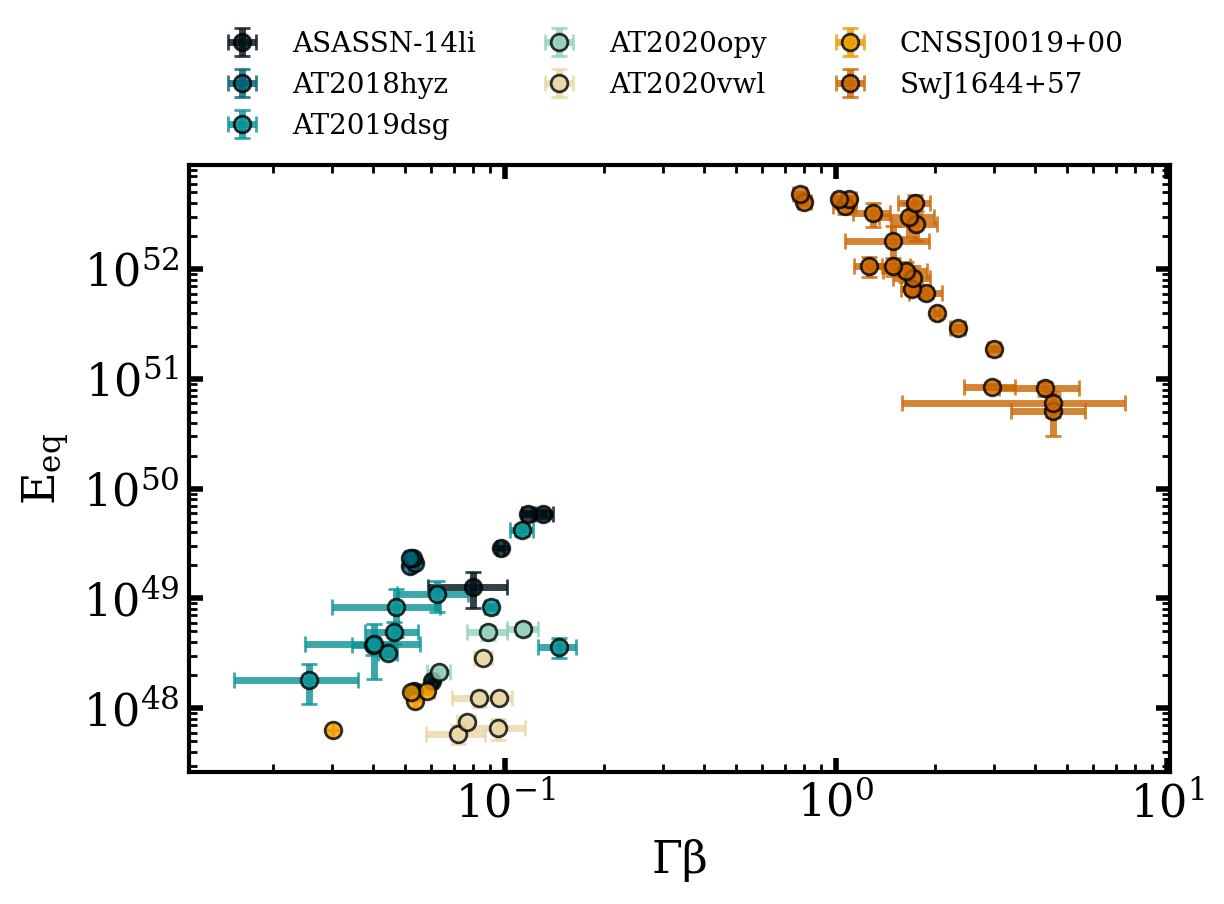

In [8]:
# energy vs gammabeta plot
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("name"):
    ax.errorbar(
        grp.gammabeta,
        grp.Eeq,
        xerr = grp.gammabeta_err,
        yerr = grp.Eeq_err,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$E_{eq}$")
ax.set_xlabel(r"$\Gamma \beta$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

In [32]:
grp.nu_m/grp.nu_a

33    [20.679325908076308, 13.450781245877193, 4.388...
34    [25.790708085420917, 19.616998694043357, 25.19...
35    [17.467118302786112, 17.631760360722637, 11.88...
36    [4.349264217362371, 4.703774786748118, 5.20647...
37    [9.511561769119135, 9.952733589966059, 9.81271...
38    [9.720730527946813, 8.741510567370797, 8.97411...
39    [5.668749902995812, 6.041379739711765, 5.68545...
40    [2.9591389327545192, 4.401220415075816, 5.2341...
41    [2.51533468940413, 2.586335148704282, 2.740752...
42    [2.018450508622561, 1.8558780674514754, 1.1717...
43    [1.9223605228283642, 1.4261422095701286, 2.055...
44    [1.6381171080639683, 1.7231579941862667, 1.734...
45    [1.7668965565312043, 1.8269429419738383, 1.736...
46    [0.5466415248174752, 0.7276001204914522, 0.621...
47    [1.1054004215905218, 0.9164306211537623, 0.807...
48    [0.8816577763347638, 0.6734176685564758, 1.116...
49    [0.6103906039609586, 0.9161413171748668, 0.680...
50    [0.6559690958768536, 0.7147632022782882, 0

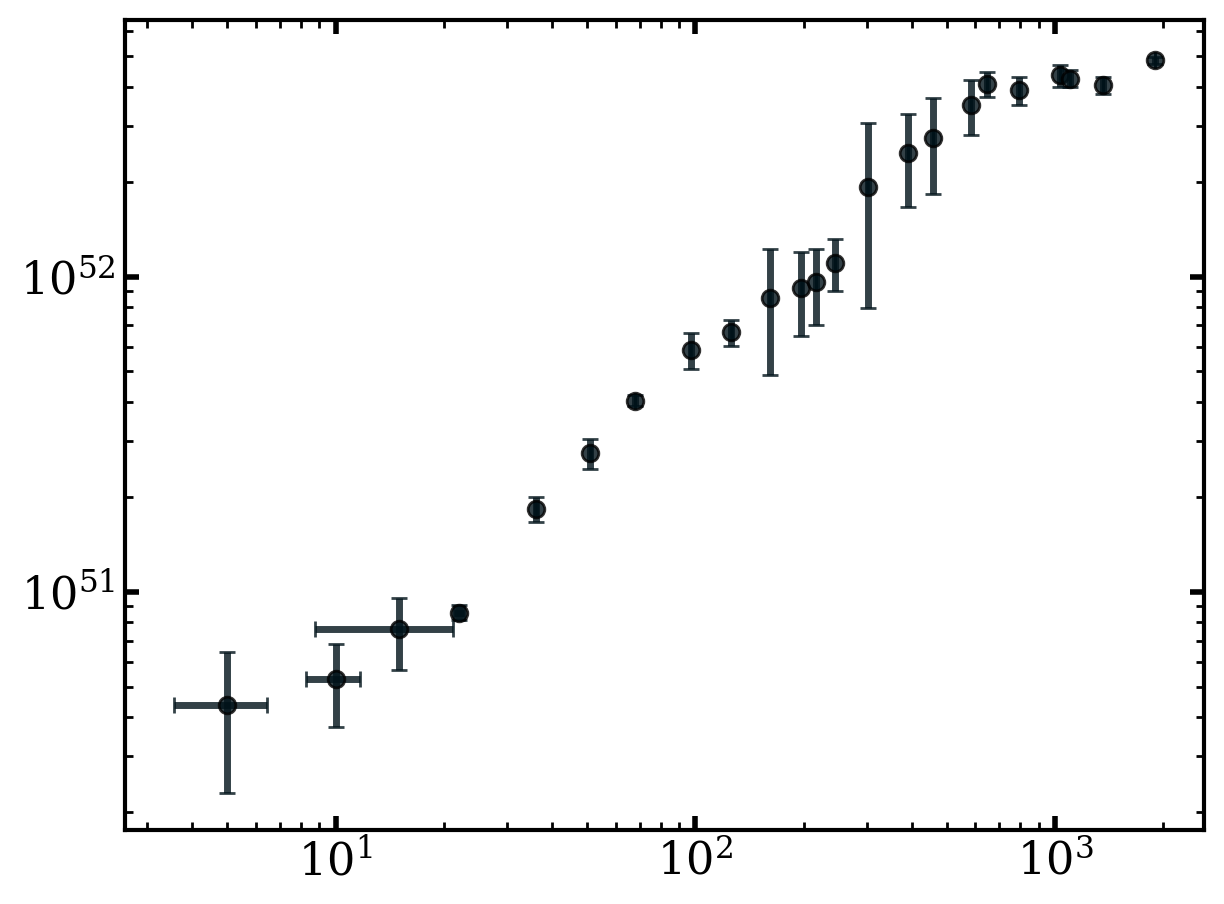

In [25]:
grp = eq_res[eq_res.name == "SwJ1644+57"]
fig, ax = plt.subplots()
ax.errorbar(
        grp.t,
        grp.Eeq,
        xerr = grp.gammabeta_err,
        yerr = grp.Eeq_err,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_yscale("log")
ax.set_xscale("log")

ASASSN-14li
AT2018hyz
AT2019dsg
AT2020opy
AT2020vwl
CNSSJ0019+00
SwJ1644+57


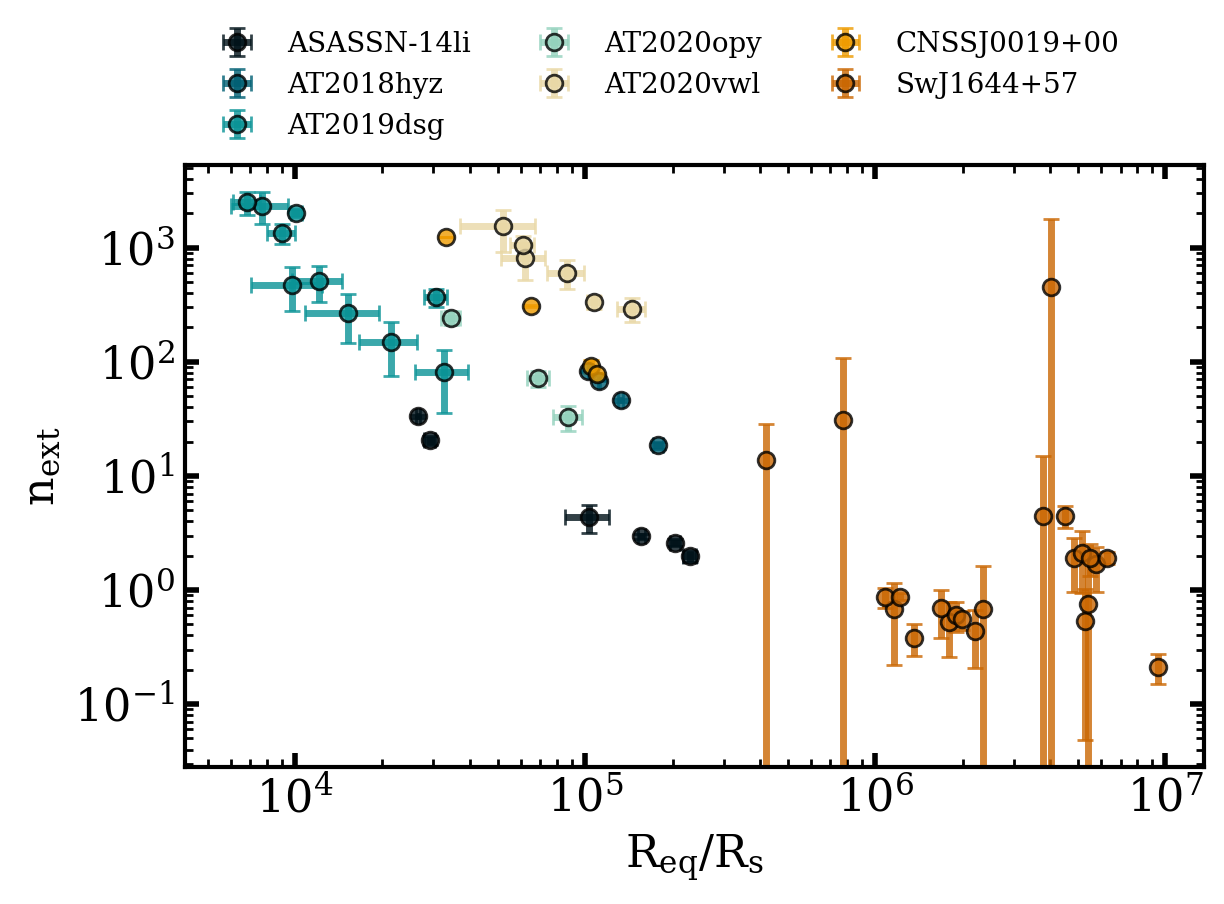

In [26]:
# density vs. radius
fig, ax = plt.subplots()
for name, grp in eq_res.groupby("name"):
    print(name)
    Mbh = 10**(bhmasses[bhmasses.name == name].bhmass.values[0]) * u.M_sun
    Mbh_err = 10**(bhmasses[bhmasses.name == name].bhmass_err.values[0]) * u.M_sun
    Rs = (2*c.G*Mbh / c.c**2).cgs.value
    Rs_err = (2*c.G*Mbh_err / c.c**2).cgs.value
    ax.errorbar(
        grp.Req/Rs,
        grp.number_density,
        xerr = np.sqrt( (grp.Req_err/Rs)**2 + (Rs_err/Rs)**2 ),
        yerr = grp.number_density_err,
        marker="o",
        linestyle="none",
        label=name,
        alpha=0.8,
        mec="k"
    )

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel(r"$n_{ext}$")
ax.set_xlabel(r"$R_{eq} / R_{s}$")
ax.legend(bbox_to_anchor=(0,1),loc="lower left", ncols=3, fontsize=10)

In [27]:
eq_res[[c for c in eq_res.columns if "_all" not in c and c not in {"F_p", "nu_p", "nu_m", "nu_a"}]].to_csv("equipartition-results.csv")